In [1]:
#######################
#
# Brandon C. Bukowski
# Mingze Zheng
# Yanqi Huang
# Geet Gupta
# Johns Hopkins University
# 04/12/2024
# Version 0.9
#
# Citations:
# Kabsch rotations: https://github.com/charnley/rmsd
# VACF: Stefan Bringuier https://zenodo.org/records/5261318 DOI: 10.5281/zenodo.5261318
# QHO: Alexopoulos, K. et al. 10.1021/acs.jpcc.6b00923
# Application: Bukowski B.C. et al. 10.1016/j.jcat.2018.07.012 
import numpy as np
from ase.io import read, write
from ase.visualize import view
import matplotlib.pyplot as plt
import scipy
from scipy import signal

In [16]:
MD_filepath = "prod_aimd/W_g.xyz"
tau = 2.0
vacf_mode = "Vib"
dt = 0.5e-15
T = 300
z_padding = 15
# a value of 0 will lead to 3N modes being calculated later
DoFs = 3
###############
# Parameters
# TO-DO - merge into argparse when moving to standalone version
#

# standard ASE filetypes are supported


# correlation time constant to calculate VACF
# default is 2, which corresponds to a correlation length of len(trajectory) / 2 
# this is usually acceptable


# choose which DoF velocities to analyze
# "Total" -- translation + rotation + vibration
# "Resid" -- rotation + vibration
# "Vib"   -- vibration
# keep in mind rotation is ideal gas total rotation.
# Recommended usage - for gas-phase molecules use "Vib" to avoid double-counting rotational modes
#                   - for adsorbate molecules use "Resid" or "Total" to use QHO approximation for all modes
# unknown strings default to "Total" and return an error


# timestep in units "s"


# number of zeros to pad FFT to increase resolution. Note this does not increase accuracy. 
# default is usually acceptable


# Temperature in units "K"


# Degrees of freedom to be multiplied by. Defaults to 3N, but it may be necessary to adjust this 
# for example if calculating QHO modes of a gas phase molecule, you may need to calculate 3N-6 modes


In [17]:
##############
#
# Important notes - the input file should be pre-processed to only include production data on the adsorbate of interest
# It is your responsibility to ensure the simulation is properly equilibrated - non-equilibrium structures will change the VDOS
# and lead to larger than expect translational, rotational, and vibrational contributions to the VDOS
#
# Remove any atoms that are not of interest for determining the entropy, i.e. surfaces, solids, solvents, etc. 
# Each unique molecule type should be calculated separately
#
# You must ensure that this trajectory does not include discontinuities around periodic boundaries
# i.e. the trajectory should be "unwrapped". There are existing software that can perform this action.
#
################

images = read(MD_filepath, index="-15000:")

In [18]:
def remove_COM_motion(images):
    """
    Takes a set of images, removes their COM motion, and returns the COM velocities
    
    Returns:
    modified set of images
    V_COM - center of mass velocities
    V_total - velocities of all atoms
    """
    len_molec = len(images[0]) # number of atoms
    
    # translate every image to the initial COM
    i_box = images[0].get_center_of_mass()
    for image in images:
        image.positions -= i_box  
        
    V_total = np.zeros((len(images),len_molec,3))
    V_COM = np.zeros((V_total.shape))

    for i in range(len(images)):
        if i == 0:
            V_total[i] = np.zeros((len_molec,3))
            V_COM[i] = np.zeros((len_molec,3))
        else:
            V_total[i,:,:] = images[i].positions - images[i-1].positions
            V_COM[i,:,:] = images[i].get_center_of_mass() - images[i-1].get_center_of_mass()

    V_total_sum = np.zeros((V_total.shape))
    V_COM_sum = np.zeros((V_COM.shape))
    
    for i in range(len(V_total[:,0,0])):
        V_total_sum[i] = np.sum(V_total[:i+1,:,:], axis=0)
        V_COM_sum[i] = np.sum(V_COM[:i+1,:,:], axis=0)

    for i in range(len(images[:])):
        images[i].positions -= V_COM_sum[i]
        
    return images, V_COM, V_total

In [19]:
def remove_rotational_motion(images):
    """
    Takes a set of images, removes their principal rotations, and returns the vibrational velocities
    
    Returns:
    modified set of images
    V_vib - vibrational velocities, no COM or rotational motion
    
    algorithm from: 
    https://en.wikipedia.org/wiki/Kabsch_algorithm
    heavily inspired by Charnely RMSD package
    https://github.com/charnley/rmsd    
    """
    def kabsch(init, final):
        Q_C = init.positions.mean(axis=0)
        P_C = final.positions.mean(axis=0)
        Q = init.positions - Q_C
        P = final.positions - P_C

        H = np.dot(np.transpose(P), Q)    #  C
        U, S, V = np.linalg.svd(H)  # V S W
        d = np.linalg.det(U)*np.linalg.det(V) < 0.0
        if d:
            U[:,-1] = -U[:,-1]

        R = np.dot(U, V)

        P = np.dot(P, R)
        P += Q_C
        return P

    len_molec = len(images[0]) # number of atoms
    for image in images[1:]:
        image.positions = kabsch(images[0], image)

    V_vib = np.zeros((len(images),len_molec,3))

    for i in range(len(images)):
        if i == 0:
            V_vib[i] = np.zeros((len_molec,3))
        else:
            V_vib[i,:,:] = images[i].positions - images[i-1].positions
            
    return images, V_vib

In [20]:
def call_vacf(data, correlation_length, masses):
    """
    Takes a set of velocities, the VACF length, and the masses to return the VACF
    
    Returns:
    Normalized mass-weighted velocity autocorrelation function for a given set of velocities
    
    algorithm adapted from: 
    VACF: Stefan Bringuier https://zenodo.org/records/5261318 DOI: 10.5281/zenodo.5261318  
    """    
    def autocorr(X):
        out = np.correlate(X, X, mode='full')
        return out[out.size // 2:]
    
    len_images = len(data[:,0,0])
    total_VACF = np.zeros(correlation_length)
    
    blocks = range(correlation_length, len_images+1, correlation_length)
    
    for t in blocks:
        for j, ms in enumerate(masses):
            for i in range(3):
                total_VACF += autocorr(ms * data[t-correlation_length:t, j, i])
    total_VACF /= total_VACF[0]
    time = np.arange(correlation_length)
    return time, total_VACF

In [21]:
def call_fft(vacf, pad_factor, dt, correlation):
    """
    Takes a VACF and returns the VDOS. Note this is set up to use a Hanning window
    There are many possible window functions in discrete signal processing that can be used
    It is worth taking a look at the trade-offs between peak accuracy and peak spillage 
    depending on your choice of window function. In our testing, this is a critically important
    factor in how the VDOS is calculated. 
    
    parameters:
    pad factor - how much zero-padding to use in the FFT
    dt - timestep in "s"
    correlation - the correlation length of the VACF
    
    Returns:
    unnormalized VDOS for a given VACF using a Hanning window function
    
    algorithm adapted from: 
    VACF: Stefan Bringuier https://zenodo.org/records/5261318 DOI: 10.5281/zenodo.5261318  
    """ 
    def fft_autocorr(AutoCorr, dt):
        fft_arry = np.fft.rfft(AutoCorr, norm="ortho") * dt
        return fft_arry    
    
    windowed_vacf = vacf * np.hanning(vacf.size)
    windowed_vacf_v = np.lib.pad(windowed_vacf, (0, vacf.size * pad_factor), "constant", constant_values=(0))
    freq = np.fft.rfftfreq(windowed_vacf_v.size, d=dt)*(1/299792458) /100 # convert to cm-1
    fft_vacf = np.abs(fft_autocorr(windowed_vacf_v, dt))
    return freq, fft_vacf

In [22]:
def integrate_VDOS(fft_normed, freq, T, DoFs):
    """
    Takes a normalized VDOS, then integrates with a QHO weight function.
    
    parameters:
    T - temperature in K
    DoFs - How many DoFs to integrate, usually an integer between 3N-6 and 3N
      
    Returns:
    Entropy in J/mol/K
    
    Alexopoulos, K. et al. 10.1021/acs.jpcc.6b00923
    Bukowski B.C. et al. 10.1016/j.jcat.2018.07.012 
    """     
    def weight_function(freqs, T):
        hbar = 6.62607015E-34
        kT = (1.380649E-23*T) # J
        x = hbar * freqs / (2*kT)
        return x/np.tanh(x) - np.log(2*np.sinh(x))

    freq_s = freq * 3e10
    set_weighted = fft_normed[1:] * weight_function(freq_s[1:], T)
    return np.trapz(set_weighted, x=freq[1:]) * DoFs * 8.314

In [23]:
len_images = len(images)
ncorr = int(np.floor(len(images) / 6))
blocks = range(ncorr, len_images+1, ncorr)
for block in blocks:
    print(block)

1121
2242
3363
4484
5605
6726


In [24]:
images[0]

Atoms(symbols='OH2', pbc=True, cell=[14.0, 15.0, 16.0])

In [25]:
view(images)
# remove COM motion and calculate COM and total velocities
images, V_COM, V_total = remove_COM_motion(images)
# V_resid is the residual velocity after removing COM motion
V_resid = V_total - V_COM
# remove principal rotations to calculate vibrational velocity.
# images are modified in-place
#images, V_vib = remove_rotational_motion(images)

In [26]:
# ncorr is the length of the VACF. Typically, longer is better
# though you want some blocks to average over. 
# I recommend tuning this value to find a converged result
ncorr = int(np.floor(len(images) / tau))
masses = images[0].get_masses()

if vacf_mode == "Vib":
    times, VACF = call_vacf(V_vib, ncorr, masses)
elif vacf_mode == "Resid":
    times, VACF = call_vacf(V_resid, ncorr, masses)
elif vacf_mode == "Total":
    times, VACF = call_vacf(V_total, ncorr, masses)
else:
    times, VACF = call_vacf(V_total, ncorr, masses)    

NameError: name 'V_vib' is not defined

In [ ]:
plt.plot(VACF)

In [ ]:
# create the initial VDOS called fft
# due to spectral leakage, there may be a nonzero fft[0]
# this is expected for a diffusing system, but problematic for vibrational modes
# here we background subtract and save it as fft_bkg
# the FFT is then normalized to 1 for integration

freq, fft = call_fft(VACF, z_padding, dt, ncorr)
fft_bkg = fft - (fft[0] / (1 + (freq)**2))
fft_normed = fft_bkg / np.trapz(fft_bkg, x=freq)
entropy = integrate_VDOS(fft_normed, freq, T, DoFs)
print(f"Entropy at {T} K with {DoFs} degrees of freedom: {entropy} J Mol-1 K-1")

Text(0, 0.5, 'normalized intensity')

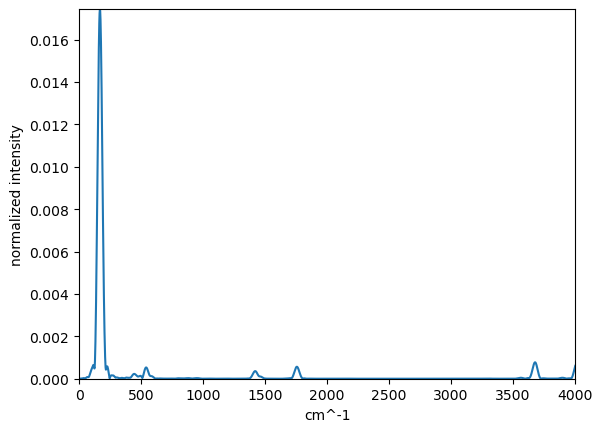

In [15]:
plt.plot(freq, fft_normed)
plt.xlim(0, 4000)
plt.ylim(0, np.max(fft_normed))
plt.xlabel("cm^-1")
plt.ylabel("normalized intensity")

In [48]:
view(images)

<Popen: returncode: None args: ['C:\\Users\\bcbuk\\anaconda3\\python.exe', '...>